# Minhash for recommendations

In the [previous notebook](04-minhash.ipynb) we saw how Minhash can be used to approximate the similarity of sets. In this notebook we will see that Minhash can also be used to make recommendations. 

We illustrate this technique using a data set which contains users' listening history from a music streaming service. If you're interested in how we generated this data, take a look at [this notebook](99a-data-generator.ipynb). 

In [203]:
import os
import pandas as pd

path = 'data/' 
files = os.listdir(path)
files_data = [i for i in files if i.startswith('userdat')][0:1] #listing all files in the directory of the correct form
df = pd.DataFrame(columns=['user', 'artist','plays'])
for j in files_data:
    pseudo_data = pd.read_parquet('data/'+j)
    df = pd.concat([df, pseudo_data])
    print(df.shape)

(2593050, 3)


The data contains three columns and over 44million rows. Let's take a closer look at a sample of the data. 

In [204]:
df.sample(10, random_state=1)

,user,artist,plays
4163,17140,69858,3
505,18032,133660,71
186,18545,142027,61
238,15553,58412,1
2052,17129,69605,9
112,18313,91561,1
349,16952,50141,259
523,15503,136162,9
480,17444,58716,13
1640,17978,62871,2


The first column is an integer representing a user id, the second is an integer representing an artist name, and the third column is an integer indicating how many times the user listened to the artist. 

We take one pass through the data to identify all unique artists all unique users and artists. 

In [205]:
artists = df['artist'].unique()
users = df['user'].unique()

In [206]:
print("There are ", len(artists), " artists and ", len(users), " users in our data." , sep="")

There are 29356 artists and 3100 users in our data.


We map those user names to unique integers and store those in a dictionary.

In [207]:
dusers = {x+1:y for x,y in enumerate(sorted(set(users)))}

In [208]:
dusers

{1: 15501,
 2: 15502,
 3: 15503,
 4: 15504,
 5: 15505,
 6: 15506,
 7: 15507,
 8: 15508,
 9: 15509,
 10: 15510,
 11: 15511,
 12: 15512,
 13: 15513,
 14: 15514,
 15: 15515,
 16: 15516,
 17: 15517,
 18: 15518,
 19: 15519,
 20: 15520,
 21: 15521,
 22: 15522,
 23: 15523,
 24: 15524,
 25: 15525,
 26: 15526,
 27: 15527,
 28: 15528,
 29: 15529,
 30: 15530,
 31: 15531,
 32: 15532,
 33: 15533,
 34: 15534,
 35: 15535,
 36: 15536,
 37: 15537,
 38: 15538,
 39: 15539,
 40: 15540,
 41: 15541,
 42: 15542,
 43: 15543,
 44: 15544,
 45: 15545,
 46: 15546,
 47: 15547,
 48: 15548,
 49: 15549,
 50: 15550,
 51: 15551,
 52: 15552,
 53: 15553,
 54: 15554,
 55: 15555,
 56: 15556,
 57: 15557,
 58: 15558,
 59: 15559,
 60: 15560,
 61: 15561,
 62: 15562,
 63: 15563,
 64: 15564,
 65: 15565,
 66: 15566,
 67: 15567,
 68: 15568,
 69: 15569,
 70: 15570,
 71: 15571,
 72: 15572,
 73: 15573,
 74: 15574,
 75: 15575,
 76: 15576,
 77: 15577,
 78: 15578,
 79: 15579,
 80: 15580,
 81: 15581,
 82: 15582,
 83: 15583,
 84: 15584,
 

In [209]:
dusers2 = users.astype("int")

In [210]:
dusers2

array([15501, 15502, 15503, ..., 18598, 18599, 18600])

We also load in a dictionary which maps from the artist integers to artist names. 

In [6]:
import pickle
file = open("data/dartists.pkl","rb")
dartists = pickle.load(file)

We want to convert the integers representing artist names back into artist names, using the dictionary. 

We group the data set by user. From there we can see which artists a particular user has listened to:

In [7]:
import numpy as np

def user_data(user, grouped_data, dusers):
    return grouped_data.get_group(dusers[user]) 

def top_k_listens(listening_history, k=10):
    top_k = listening_history.sort_values(by="plays", ascending = False)["artist"].head(k).values
    return artist_names(top_k)

def artist_names(artist_ints, artist_dic = dartists):
    return [artist_dic[k] for k in artist_ints]

In [8]:
df.sample(10)

,user,artist,plays
76,18295,129664,2
3280,17108,144298,1
47,17086,13740,152
192,17045,145255,20
304,16028,141694,53
817,17350,82737,41
526,16057,146203,1
180,16821,142902,1
340,17202,75739,124
96,17351,48097,1


In [9]:
grouped_df = df.groupby(['user'])

For a particular user we can have a look at their listening history as well as their most listened to artists. 

In [10]:
import numpy as np
u100 = user_data(100, grouped_df, dusers)
u100_samp = u100.sample(10)

In [11]:
u100_samp

,user,artist,plays
381,15600,172138,2
209,15600,138431,1
30,15600,50627,8
1,15600,164235,49
233,15600,9303,6
26,15600,150953,2
241,15600,56883,114
363,15600,22794,16
334,15600,128642,22
32,15600,83183,6


In [12]:
top_k_listens(u100, 10)

['The Grouch & Eligh',
 'Sara Valenzuela',
 'Gb Interprets Little Dragon',
 'Objects',
 'Mondo Generator',
 '松下里美',
 'Priest Brooks',
 'Funkhead Fred & Matty Wells Vs. The Touch',
 'Arnold Mcculler & Paul Giamatti',
 'Mr. Projectile']

For each user, we want to generate a minhash of their listening history. The minhash class which we used in the previous notebook has been put into its own module for ease. 

In [13]:
from datasketching.minhash import SimpleMinhash
from datasketching.minhash import murmurmaker

In [14]:
def generate_minhash_sig(user_dat, nhash):
    mh = SimpleMinhash(nhash)
    for row in user_dat:
        mh.add(row)
    return mh

So for each user, we want to compose a list of all the artists they listened to. From there we will generate minhashes for each user, then make predictions. 

In [15]:
un_artists = grouped_df['artist']

In [16]:
## this next cell takes about ten minutes to run with 128 nhash
## 80 minutes with 1024 hash functions. 

In [17]:
import time

start = time.time()
mh_sigs = un_artists.apply(generate_minhash_sig, nhash = 128)
end = time.time()

print(end-start)

305.8295018672943


Once we have minhash signatures for all of the users we can compare them. But this isnt a quick process - suppose we want to find users who are similar to user 2. 

In [18]:
sim=[]
for mh in range(1, len(mh_sigs)):
    sim.append(mh_sigs[dusers[mh]].similarity(mh_sigs[dusers[100]]))

Let's take a look at the users who are most similar to user 2:

In [19]:
similar = set(sorted(sim, reverse = True)[1:10])
similar_users = ([i for i, e in enumerate(sim) if e in similar])
for j in similar_users:
    print(dusers[j])

15555
15558
15568
15574
15577
15579
15587
15589
15593
15598


These are the most similar users. Let's go ahead and look at the top artists listened to by all these users. 

Going to look at the unique artists listened to by each of these, remove uniques listened to by user 2, and then return the most listened across the other users. 

Look at the ?top 10 artists most listened to by these users that our user didnt listen to. 

In [20]:
unheard = []
for u in similar_users:
    u_dat = user_data(u, grouped_df, dusers)
    unheard = unheard + list(top_k_listens(u_dat, 2))

In [21]:
unheard

['Skip Bifferty',
 'Weston',
 'Алла Иошпе',
 'Scanty',
 'Booka Shade Con Many Chelonis E R Jones',
 'The Hilliard Ensemble [Ensemble]',
 'Sandra Oxenryd',
 'Steve "Silk" Hurley',
 'Old Jerusalem',
 'Jerry Rivera Y Voltio',
 'B-Side',
 'Eddie Floyd',
 'Jazz Split',
 'The Volcanoes',
 'Vanilla Fudge',
 'Junior Reid And Don Carlos',
 'Funkhead Fred & Matty Wells Vs. The Touch',
 'Xiii',
 'Autobianchi',
 'Andero Ermel']

So that's just a quick example of how we can use minhash to identify songs we should recommend to a particular user. This method works fine on a small number of users, but falls into dificulty when the number of users grows, and the number of users for which we want to make recommendations for grows. 

Time to compute similarity between pairs of users:

In [49]:
npairs = [10, 25, 50, 75, 100, 200, 300, 500, 750, 1000]
times = []
for pairs in npairs:
    start = time.time()
    sim=[]
    for i in range(1, pairs):
        for j in range((i+1), pairs):
            sim.append(mh_sigs[dusers[i]].similarity(mh_sigs[dusers[j]]))
    end = time.time()    
    times.append((pairs, end-start))

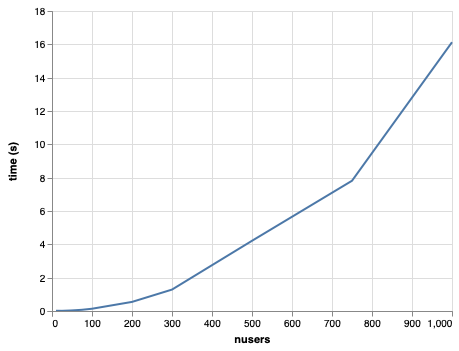

In [51]:
import altair as alt

times_df = pd.DataFrame.from_records(times)
times_df.rename(columns={0:"nusers", 1:"time (s)"}, inplace=True)
alt.renderers.enable('notebook')
alt.Chart(times_df).mark_line().encode(x="nusers", y="time (s)")

## Locality-Sensitive Minhash

One big disadvantage of using Minhash signatures to identify similar users is the number of pairwise comparisons which must be made to determine similarity. 

Locality-sensitive Minhash is a technique we can use to identify candidate pairs of similar users for a much smaller computational cost. The method works by hashing subsets minhash signatures. If 2 users have identical signatures in ANY of the subsets these users are considered a candidate pair. And from there you can go and compute their approximate Jaccard index, or similarity, using the full minhash signatures, to determine just how similar they are, and decide if you want to make recommendations. 

The way in locality sensitive minhash works is by splitting the minhash signatures into bands. The bands are then hashed to buckets. 

if, in any band, two users map to the same bucket, they would be considered a candidate pair. At that point you’d go back and look at their minhash signatures, and compare those to determine how similar the users are. 


And thus we only have to compute the similarity of the minhash signatures for a subset of the whole population. 

In [52]:
from datasketching.minhash import LSHMinhash
import random

In [53]:
def lsmh(mh_sig, bands):
    ### assumes that the lenth of the mhsig is divisible by bands. 
    ### make more robust
    rows = int(len(mh_sig.buckets)/bands)
    return [mh_sig.hashes[0]([b for b in band]) for band in mh_sig.buckets.copy().reshape((rows, bands))]
    

In [197]:
from collections import defaultdict

bands = [defaultdict(lambda: list()) for i in range(16)]

for ind, mh_sg in enumerate(mh_sigs):
    for idx, key in enumerate(lsmh(mh_sg, bands=16)):
        bands[idx][key % (1 << 14)].append(ind+1)

We've made a dictionary of values for each band, where the keys correspond to buckets, and the values are indexes of minhash signature which mapped to that bucket. 

If two minhash signatures hash to the same key in ANY band we consider them to be 'candidate pairs'. 

This means that the corresponding users _may_ be similar. We can check if they are similar by comparing the set of artists they have each listend to. From there we can use this information to make recomendations, or move on to consider other candidate pairs. 

We loop over the bands, extracting any candidate pairs. We also map to usernames at this point. 

In [201]:
## we now extract all candidate pairs
import itertools
candidates = []
for b in bands:
    for it in b.items():
        if len(it[1])>1:
            candidates.extend(list(itertools.combinations(it[1], 2)))


In [202]:
user_pairs = []
for i in candidates[7281:7290]:
    user_pairs.extend((dusers[i[0]], dusers[i[1]]))

In [99]:
test = candidates[0]

In [102]:
(dusers[test[0]], dusers[test[1]])

(15502, 15519)

In [118]:
for i in candidates:
    print([dusers[i[0]], dusers[i[1]]])

[15502, 15519]
[15504, 16160]
[15504, 16299]
[16160, 16299]
[15506, 16632]
[15507, 15543]
[15516, 17319]
[15522, 17813]
[15524, 15779]
[15524, 18448]
[15779, 18448]
[15526, 16345]
[15528, 17589]
[15549, 17552]
[15560, 17244]
[15560, 17413]
[17244, 17413]
[15561, 15777]
[15562, 17736]
[15565, 15581]
[15565, 17554]
[15581, 17554]
[15569, 17066]
[15571, 15744]
[15587, 16246]
[15594, 16672]
[15596, 16251]
[15596, 16254]
[15596, 16265]
[15596, 16275]
[15596, 16290]
[16251, 16254]
[16251, 16265]
[16251, 16275]
[16251, 16290]
[16254, 16265]
[16254, 16275]
[16254, 16290]
[16265, 16275]
[16265, 16290]
[16275, 16290]
[15598, 15998]
[15600, 17606]
[15605, 16605]
[15607, 17145]
[15609, 16120]
[15618, 17701]
[15634, 16589]
[15641, 15649]
[15642, 16501]
[15656, 18035]
[15660, 15678]
[15661, 15940]
[15664, 17626]
[15668, 17846]
[15671, 16884]
[15673, 18276]
[15675, 17439]
[15676, 18105]
[15680, 17272]
[15683, 15862]
[15686, 17333]
[15688, 16905]
[15689, 16449]
[15697, 18074]
[15705, 15725]
[15705, 16

[16455, 16493]
[16455, 16494]
[16455, 16496]
[16455, 16499]
[16459, 16464]
[16459, 16465]
[16459, 16467]
[16459, 16468]
[16459, 16470]
[16459, 16471]
[16459, 16472]
[16459, 16473]
[16459, 16475]
[16459, 16476]
[16459, 16479]
[16459, 16480]
[16459, 16483]
[16459, 16484]
[16459, 16486]
[16459, 16487]
[16459, 16488]
[16459, 16489]
[16459, 16490]
[16459, 16493]
[16459, 16494]
[16459, 16496]
[16459, 16499]
[16464, 16465]
[16464, 16467]
[16464, 16468]
[16464, 16470]
[16464, 16471]
[16464, 16472]
[16464, 16473]
[16464, 16475]
[16464, 16476]
[16464, 16479]
[16464, 16480]
[16464, 16483]
[16464, 16484]
[16464, 16486]
[16464, 16487]
[16464, 16488]
[16464, 16489]
[16464, 16490]
[16464, 16493]
[16464, 16494]
[16464, 16496]
[16464, 16499]
[16465, 16467]
[16465, 16468]
[16465, 16470]
[16465, 16471]
[16465, 16472]
[16465, 16473]
[16465, 16475]
[16465, 16476]
[16465, 16479]
[16465, 16480]
[16465, 16483]
[16465, 16484]
[16465, 16486]
[16465, 16487]
[16465, 16488]
[16465, 16489]
[16465, 16490]
[16465, 16

[18556, 18596]
[18562, 18567]
[18562, 18592]
[18562, 18596]
[18567, 18592]
[18567, 18596]
[18592, 18596]
[18572, 18573]
[15503, 15520]
[15503, 15523]
[15503, 15532]
[15520, 15523]
[15520, 15532]
[15523, 15532]
[15504, 16252]
[15512, 15516]
[15534, 17943]
[15541, 18088]
[15555, 16708]
[15557, 15846]
[15562, 17723]
[15567, 16700]
[15579, 16979]
[15585, 18052]
[15588, 16914]
[15588, 17528]
[16914, 17528]
[15595, 18429]
[15603, 15639]
[15606, 15627]
[15610, 15624]
[15616, 18278]
[15619, 17316]
[15625, 18476]
[15636, 17845]
[15652, 16126]
[15654, 18029]
[15667, 15688]
[15672, 17812]
[15674, 17955]
[15684, 16202]
[15684, 16228]
[15684, 16233]
[16202, 16228]
[16202, 16233]
[16228, 16233]
[15689, 17123]
[15691, 18175]
[15694, 16363]
[15694, 16377]
[16363, 16377]
[15696, 18452]
[15700, 15730]
[15700, 15736]
[15700, 15742]
[15730, 15736]
[15730, 15742]
[15736, 15742]
[15704, 15718]
[15706, 17788]
[15709, 15721]
[15709, 17501]
[15721, 17501]
[15710, 17814]
[15732, 15734]
[15750, 16685]
[15750, 16

KeyError: 0